In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

## Results Data

In [2]:
res_df = pd.read_csv("./models/results.csv")

res_df.head()

,i,type,loss_val,code_size,optimizer,loss_func,epochs,batch_size,filepath
0,0,bryan,21.345753,2,adam,mse,150,32,models/encoder_bryan_cs-2_loss-mse_bs-32.h5
1,1,bryan,18.617182,2,adam,mse,150,128,models/encoder_bryan_cs-2_loss-mse_bs-128.h5
2,2,bryan,17.751451,3,adam,mse,150,32,models/encoder_bryan_cs-3_loss-mse_bs-32.h5
3,3,bryan,19.478971,3,adam,mse,150,128,models/encoder_bryan_cs-3_loss-mse_bs-128.h5
4,4,bryan,14.920699,4,adam,mse,150,32,models/encoder_bryan_cs-4_loss-mse_bs-32.h5


In [3]:
print("len =", len(res_df))
print("type =", res_df["type"].unique())
print("code_size =", res_df["code_size"].unique())
print("batch_size =", res_df["batch_size"].unique())
print("optimizer =", res_df["optimizer"].unique())
print("loss_func =", res_df["loss_func"].unique())
print("epochs =", res_df["epochs"].unique())

len = 150
type = ['bryan' 'default' 'oit_bryan_allpos' 'oit_bryan' 'oit']
code_size = [ 2  3  4  5  6 12 18 24 30 36 42 48 54 60 72]
batch_size = [ 32 128]
optimizer = ['adam']
loss_func = ['mse']
epochs = [150]


## Validation Data

In [4]:
validation_df = pd.read_csv("./models/validations.csv")

validation_df.head()

,Unnamed: 0,accuracy_knn,accuracy_nn,loss_nn,filepath
0,0,0.257982,0.252448,1.795123,models/encoder_bryan_cs-2_loss-mse_bs-32.h5
1,1,0.255854,0.252448,1.674897,models/encoder_bryan_cs-2_loss-mse_bs-128.h5
2,2,0.124734,0.107280,28.862000,models/encoder_bryan_cs-3_loss-mse_bs-32.h5
3,3,0.273308,0.252448,1.870426,models/encoder_bryan_cs-3_loss-mse_bs-128.h5
4,4,0.199234,0.218391,19.113821,models/encoder_bryan_cs-4_loss-mse_bs-32.h5


# Utils

In [5]:
def get_losses_by_code_size(df):
    x = list(df["code_size"])
    y = list(df["loss_val"])
    return x, y


# Analysis

Check models on default types. We want to find out whether `batch_size` is relevant or not. 

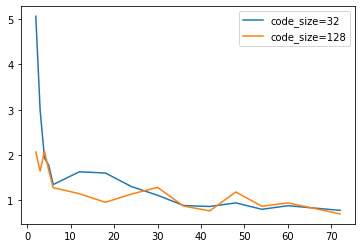

In [8]:
df = res_df.loc[(res_df["type"] == "default") & (res_df["batch_size"] == 32)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, label="code_size=32")

df = res_df.loc[(res_df["type"] == "default") & (res_df["batch_size"] == 128)]
x, y = get_losses_by_code_size(df)
plt.plot(x, y, label="code_size=128")

plt.legend()
plt.show()

We noticed that with batch size of 32 we could be more robust in term of oscillation, but batch size of 128 could archieve better results. We decided to keep batch size of **128** because it performs better on small codes. 

Let's now analyse results with bacht size of 128. We would like to compare how the autoencoder performs in term of loss (mse in our case) on different scenarios:

1. controlled data + ab validation
2. controlled data + ab validation + oit
3. controlled data + bryan validation
4. controlled data + bryan validation + oit
5. controlled data + bryan validation (all positions) + oit

We should see that performances on 1 vs 2 should be pretty the same or lower for 2. We shoudl also see that performances on 1 vs 3-4-5 shoudl be higher for 1 (if this is not the case the model is generalizing well). For 3-4-5 we shoudl see that 3 is very poor in performances, while 4 should be very good wrt 3 and the same or slightly lower than 1-2. For 5 wrt 4 we should notice slightly low performances.

# Old

Compare losses on different datasets.

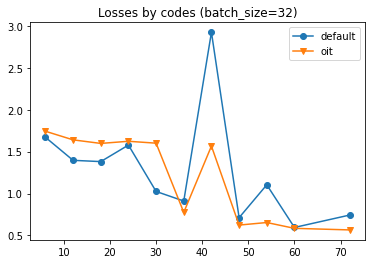

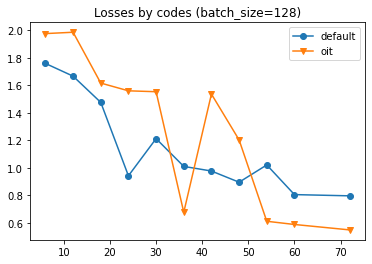

In [13]:

def plot_losses_by_code_size(batch_size, optimizer, loss_func, epochs):

    df = data_df.loc[(data_df["batch_size"] == batch_size) & (data_df["optimizer"] == optimizer) & (data_df["loss_func"] == loss_func) & (data_df["epochs"] == epochs)]
    df = df.groupby(["type"])

    x1, y1 = get_losses_by_code_size(df.get_group("default"))
    x2, y2 = get_losses_by_code_size(df.get_group("oit"))
    #x3, y3 = get_losses_by_code_size(df.get_group("oit_bryan"))
    #x4, y4 = get_losses_by_code_size(df.get_group("oit_bryan_allpos"))


    plt.plot(x1, y1, marker="o", label="default")
    plt.plot(x2, y2, marker="v", label="oit")
    #plt.plot(x3, y3, marker="s", label="oit_bryan")
    #plt.plot(x4, y4, marker="D", label="oit_bryan_allpos")

    plt.legend()
    

plot_losses_by_code_size(optimizer="adam", loss_func="mse", epochs=150, batch_size=32)
plt.title("Losses by codes (batch_size=32)")
plt.show()

plot_losses_by_code_size(optimizer="adam", loss_func="mse", epochs=150, batch_size=128)
plt.title("Losses by codes (batch_size=128)")
plt.show()